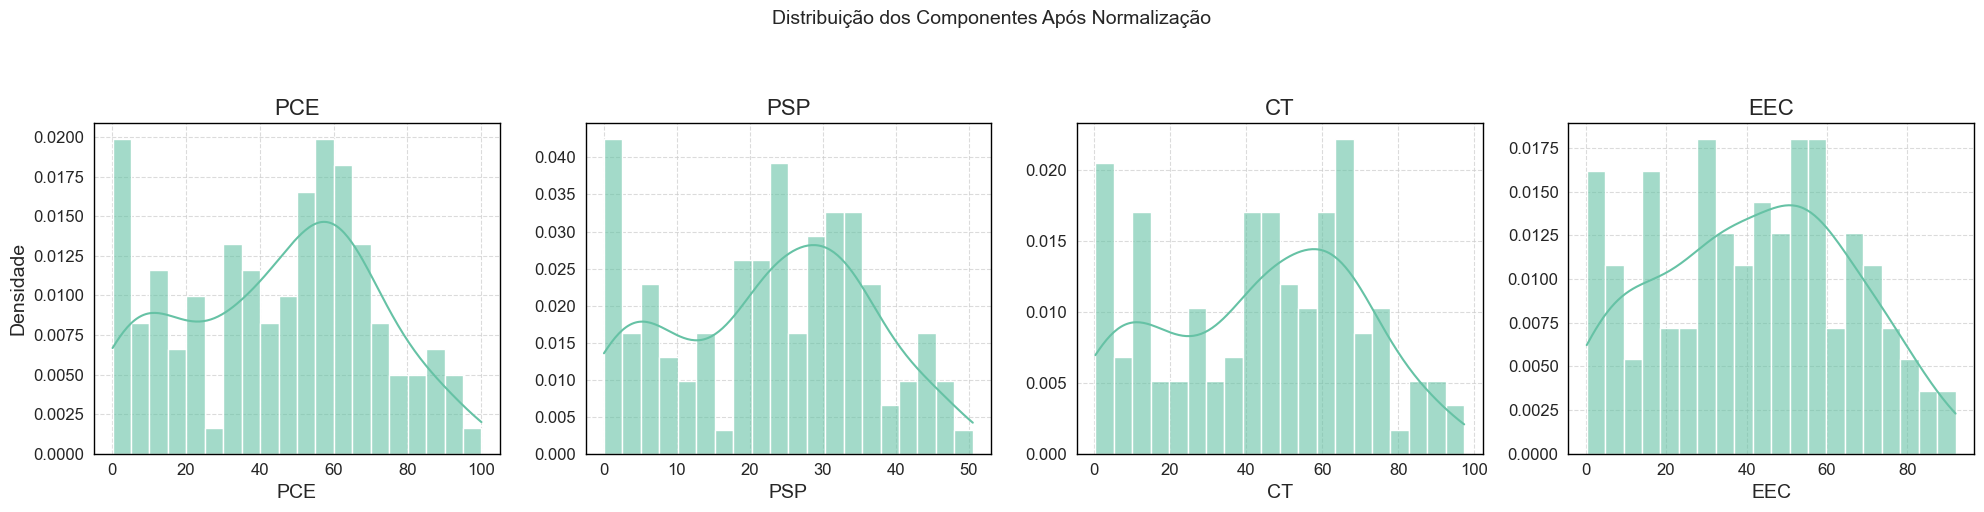

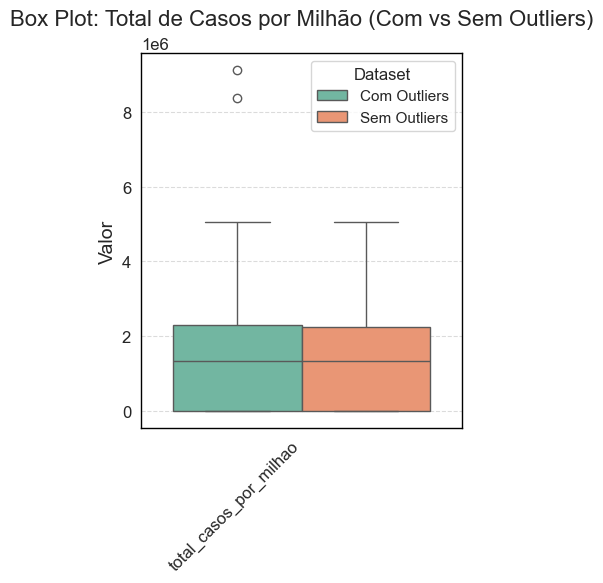

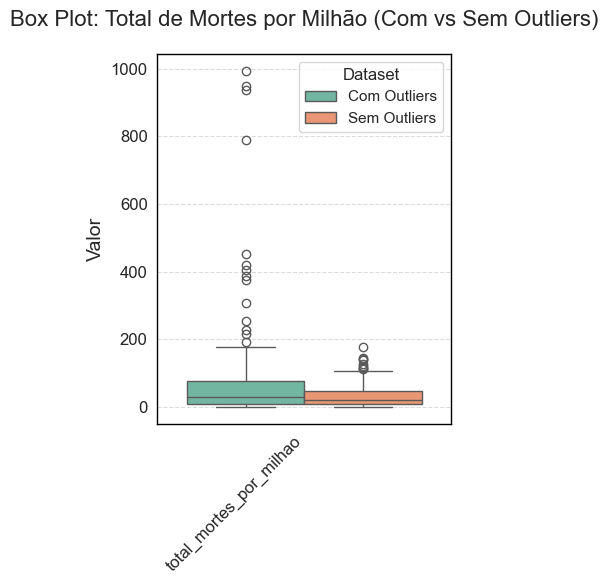

C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\callback.py:386: UserWarning: [01:10:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\USUARIO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:10:43] WA

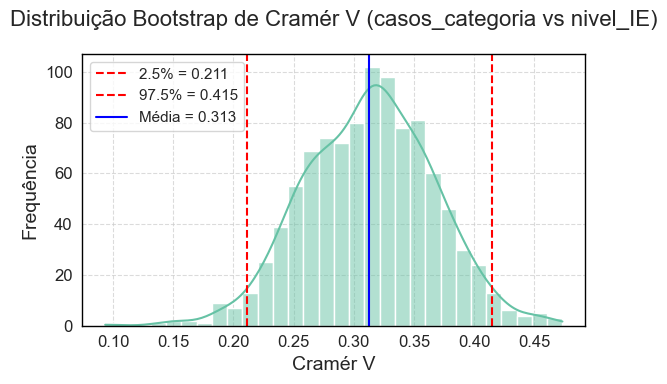

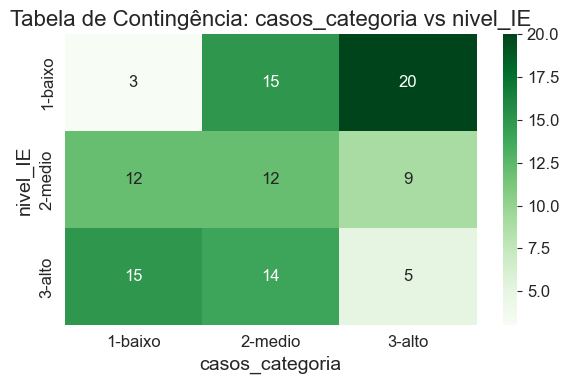

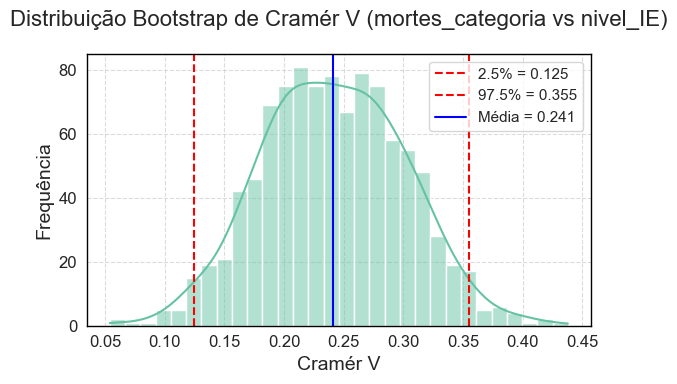

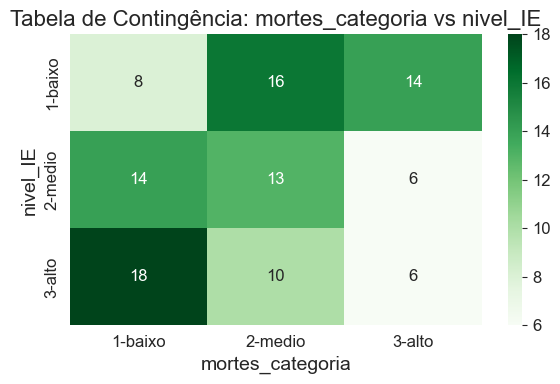

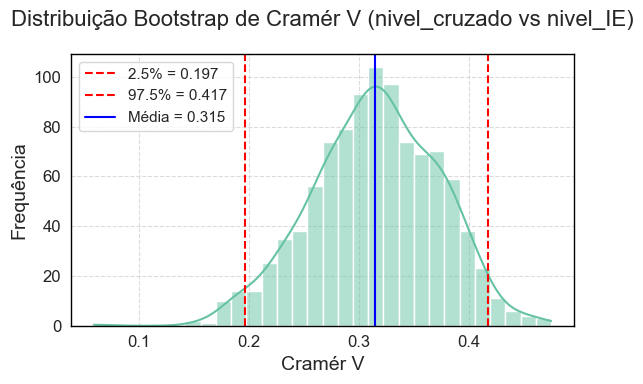

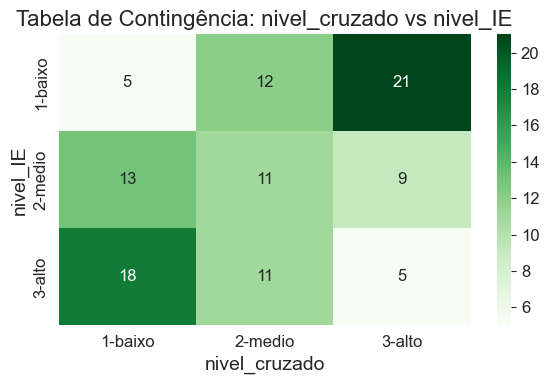

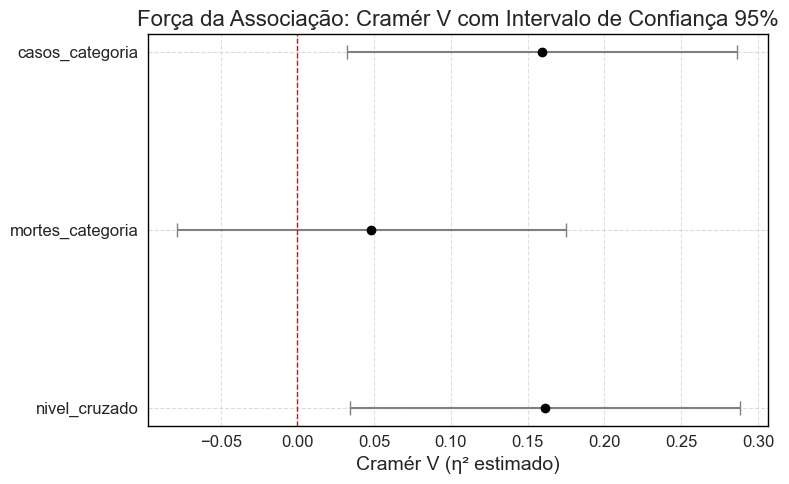

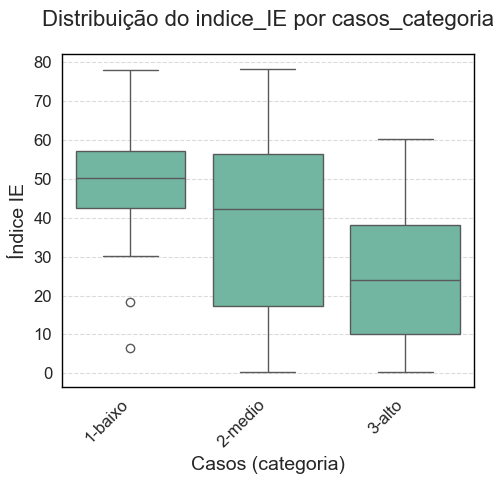

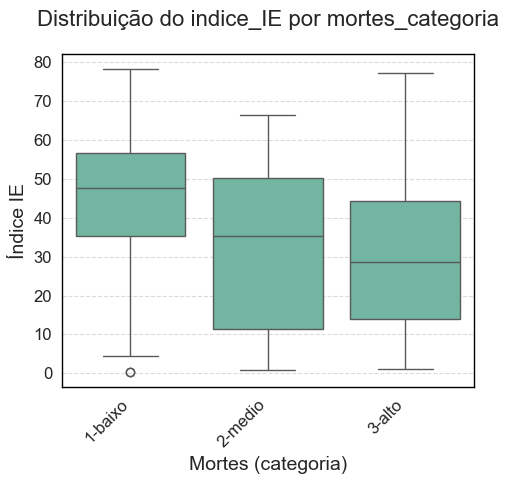

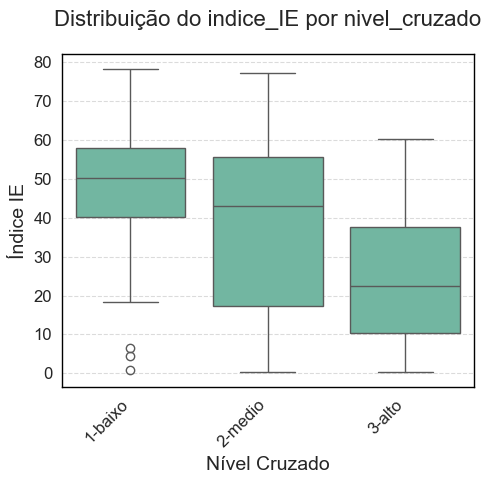

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14176\3233967963.py:1218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=var, y='indice_IE', data=data_no_outliers, inner='box', palette='Set2')


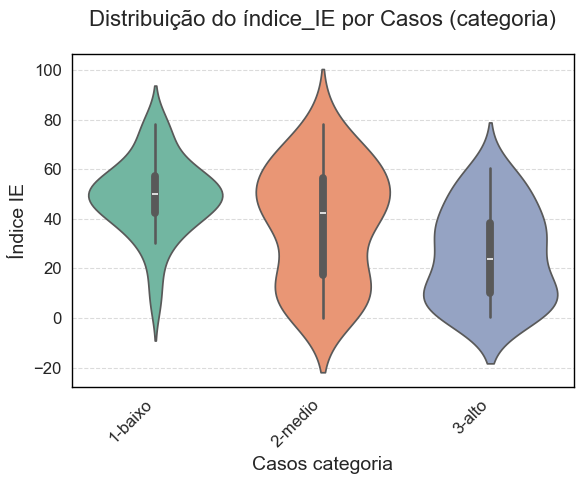

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14176\3233967963.py:1218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=var, y='indice_IE', data=data_no_outliers, inner='box', palette='Set2')


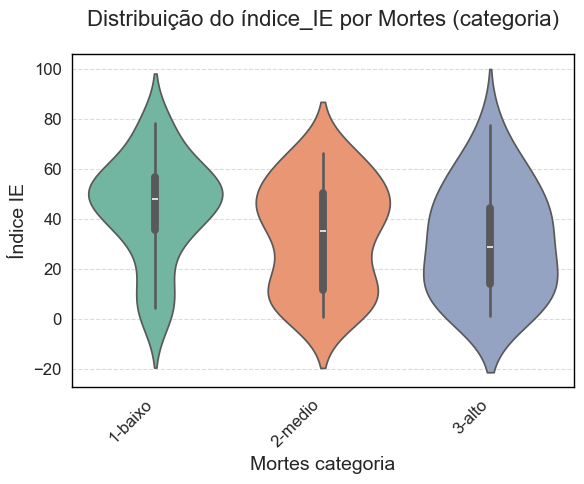

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_14176\3233967963.py:1218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=var, y='indice_IE', data=data_no_outliers, inner='box', palette='Set2')


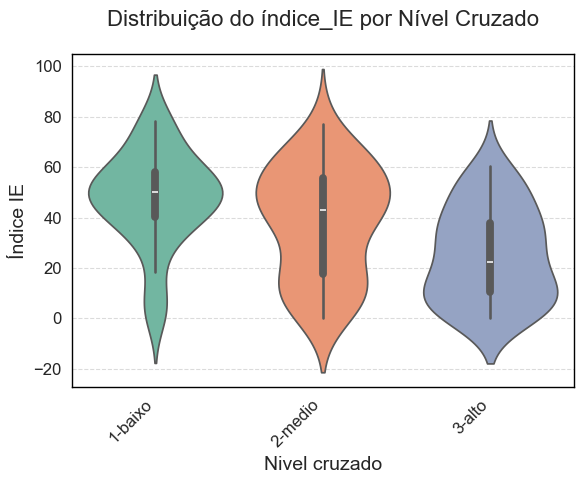

In [1]:
# Importação das bibliotecas necessárias
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import inspect
from scipy.stats import chi2_contingency, shapiro, levene, f_oneway, kruskal, skew
from scikit_posthocs import posthoc_dunn
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.utils import resample
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from statsmodels.miscmodels.ordinal_model import OrderedModel

# # Configurações globais para visualizações, definindo estilo, tamanho das fontes e layout dos gráficos.
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12,              
    'axes.titlesize': 16,         
    'axes.labelsize': 14,         
    'xtick.labelsize': 12,        
    'ytick.labelsize': 12,        
    'legend.fontsize': 11,        
    'figure.figsize': (10, 6),    
    'axes.grid': True,            
    'grid.linestyle': '--',       
    'grid.alpha': 0.7,           
    'axes.edgecolor': 'black',    
    'axes.linewidth': 1.0,       
    'figure.dpi': 100,            
})
set2_colors = sns.color_palette('Set2')

# Criar arquivo de texto
text_file = open("saida_texto.txt", "w", encoding="utf-8")
original_stdout = sys.stdout
sys.stdout = text_file

# Verifica se há valores nulos no DataFrame. Se houver, levanta um erro para garantir integridade antes da análise
def verificar_e_manipular_nulos(df, nome_dataset, colunas_clave=['pais'], colunas_numericas=None):
    if df.isnull().sum().sum() == 0:
        print(f"Nenhum valor nulo foi encontrado nos conjuntos de dados ({nome_dataset}).")
        return df
    else:
        raise ValueError(f"Valores nulos encontrados em {nome_dataset}. Revisar os dados.")

# Função para gerar SI_dataset.csv a partir de dados de dimensões culturais e COVID-19
def gerar_SI_dataset(dados_culturais, dados_covid):
    # Verificar se há duplicatas nos dados de entrada
    print("Verificando duplicatas em dados_culturais...")
    duplicated_culturais = dados_culturais.duplicated(subset=['pais']).sum()
    if duplicated_culturais > 0:
        print(f"Aviso: {duplicated_culturais} linhas duplicadas encontradas em dados_culturais (chave 'pais'). Removendo duplicatas...")
        dados_culturais = dados_culturais.drop_duplicates(subset=['pais']).reset_index(drop=True)
    
    print("Verificando duplicatas em dados_covid...")
    duplicated_covid = dados_covid.duplicated(subset=['pais']).sum()
    if duplicated_covid > 0:
        print(f"Aviso: {duplicated_covid} linhas duplicadas encontradas em dados_covid (chave 'pais'). Removendo duplicatas...")
        dados_covid = dados_covid.drop_duplicates(subset=['pais']).reset_index(drop=True)
    
    # Unindo dados de dimensões culturais e da COVID-19
    print(f"Dimensões antes da fusão: dados_culturais={dados_culturais.shape}, dados_covid={dados_covid.shape}")
    data = dados_culturais.merge(dados_covid, on='pais', how='inner')
    print(f"Dimensão após a fusão: data={data.shape}")
    
    # Verificar se há duplicatas após a mesclagem
    duplicated_merged = data.duplicated().sum()
    if duplicated_merged > 0:
        print(f"Aviso: {duplicated_merged} linhas duplicadas encontradas após a mesclagem. Removendo duplicatas...")
        data = data.drop_duplicates().reset_index(drop=True)
        print(f"Dimensão após remoção de duplicatass: data={data.shape}")
    
    # Verificar que as colunas usadas nos cálculos sejam numéricas
    colunas_calculo = ['individualismo_comunitarismo', 'especifico_difuso', 'sequencial_sincronico',
                       'neutro_afetivo', 'passado_presente_futuro']
    for col in colunas_calculo:
        if not pd.api.types.is_numeric_dtype(data[col]):
            raise ValueError(f"A coluna '{col}' não é numérica. Verificar os dados.")
            
    # Verificar se os valores estão dentro do intervalo esperado [0, 100]
    for col in colunas_calculo:
        if data[col].min() < 0 or data[col].max() > 100:
            raise ValueError(f"A coluna '{col}' contém valores fora do intervalo esperado [0, 100].")
    
    # Calcular a constante fator_IE
    data['fator_IE'] = (300 - (data['individualismo_comunitarismo'] + data['especifico_difuso'] + data['sequencial_sincronico'])) / 300
    
    # Calcule os componentes brutos da Inteligência Espiritual
    data['PCE_raw'] = (((100 - data['individualismo_comunitarismo']) * 0.5 + (100 - data['especifico_difuso']) * 0.5) * data['fator_IE'])
    data['PSP_raw'] = (((100 - data['individualismo_comunitarismo']) * 0.5 + (-4 * ((data['passado_presente_futuro'] - 50) / 50)**2 + 1) * 0.5) * data['fator_IE'])
    data['CT_raw'] = (((100 - data['especifico_difuso']) * 0.5 + (100 - data['sequencial_sincronico']) * 0.5) * data['fator_IE'])
    data['EEC_raw'] = (((100 - data['neutro_afetivo']) * 0.5 + (100 - data['sequencial_sincronico']) * 0.5) * data['fator_IE'])
    
    # Salvar uma cópia dos componentes não normalizados para análise
    componentes_raw = ['PCE_raw', 'PSP_raw', 'CT_raw', 'EEC_raw']
    
    # Normalizar componentes da IE (PCE, PSP, CT, EEC) de 0 a 100
    componentes = ['PCE', 'PSP', 'CT', 'EEC']
    todos_valores = pd.concat([data[col] for col in componentes_raw])
    min_global = todos_valores.min()
    max_global = todos_valores.max()

    for raw, norm in zip(componentes_raw, componentes):
        if max_global != min_global:
            data[norm] = (data[raw] - min_global) / (max_global - min_global) * 100
        else:
            data[norm] = 0  # Caso todos os valores sejam iguais
    
    # Calcular indice_IE como a média dos componentes normalizados
    data['indice_IE'] = data[componentes].mean(axis=1)
    
    # Calcular nivel_IE
    percentis_dinamicos = data['indice_IE'].quantile([0.3333, 0.6666]).values
    data['nivel_IE'] = pd.cut(data['indice_IE'], 
                                       bins=[-np.inf, percentis_dinamicos[0], percentis_dinamicos[1], np.inf], 
                                       labels=['1-baixo', '2-medio', '3-alto'])
    
    return data

# Obter características
def obter_features(dataset, exclude_pce_psp=False):
    expected_features = ['PCE', 'PSP', 'CT', 'EEC']
    if exclude_pce_psp:
        expected_features = ['CT', 'EEC']
    features = [col for col in expected_features if col in dataset.columns]
    if not features:
        raise ValueError("Nenhuma característica válida encontrada no dataset.")
    return features

# Categorizar percentis
def categorizar_percentil(serie, labels=['1-baixo', '2-medio', '3-alto']):
    if serie.nunique() <= 1:
        print(f"Aviso: A série {serie.name} tem variabilidade insuficiente (todos os valores são iguais). Atribuindo categoria '1-baixo' por padrão.")
        return pd.Series([labels[0]] * len(serie), index=serie.index)
    percentis = serie.quantile([0.333, 0.667]).values
    if percentis[0] == percentis[1]:
        print(f"Aviso: Percentis iguais para {serie.name}. Ajustando para evitar bins duplicados.")
        percentis[1] += 1e-6  # Pequeno ajuste para evitar bins idênticos
    return pd.cut(serie, bins=[-np.inf, *percentis, np.inf], labels=labels)

# Definir os níveis cruzados com base em casos e mortes
def definir_nivel_cruzado(c, m, q1, q2):
    valor = (c + 2 * m) / 3
    if valor < q1:
        return '1-baixo'
    elif valor < q2:
        return '2-medio'
    else:
        return '3-alto'

# Calcula a medida de associação Cramér V entre duas variáveis categóricas a partir de uma matriz de contingência
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Calcula Cramér V com bootstrapping para estimar média e intervalo de confiança entre duas variáveis categóricas
def bootstrap_cramers_v(data, col1, col2, n_iterations=1000, random_state=42):
    np.random.seed(random_state)
    values = []
    
    for _ in range(n_iterations):
        sample = data.sample(frac=1, replace=True)
        table = pd.crosstab(sample[col1], sample[col2])
        chi2, _, _, _ = chi2_contingency(table)
        n = table.sum().sum()
        min_dim = min(table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan
        values.append(cramers_v)
        
    values = np.array(values)
    mean = np.nanmean(values)
    lower = np.nanpercentile(values, 2.5)
    upper = np.nanpercentile(values, 97.5)
    
    return mean, lower, upper, values

# Função para identificar outliers usando o método IQR
def identificar_outliers(data, coluna, iqr_factor=1.5):
    Q1 = data[coluna].quantile(0.25)
    Q3 = data[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - iqr_factor * IQR
    limite_superior = Q3 + iqr_factor * IQR
    outliers = data[(data[coluna] < limite_inferior) | (data[coluna] > limite_superior)]
    return outliers

# Preparar dados e calcular pesos de classe
def preparar_dados(X_scaled, y, label_encoder, nome_target):
    # Verificar consistência das classes
    expected_classes = ['1-baixo', '2-medio', '3-alto']
    actual_classes = list(label_encoder.classes_)
    if not all(cls in expected_classes for cls in actual_classes):
        raise ValueError(f"As classes no LabelEncoder ({actual_classes}) contêm valores inesperados. Esperado: {expected_classes}")

    if len(actual_classes) < len(expected_classes):
        print(f"Aviso: Nem todas as classes esperadas estão presentes para {nome_target}. Classes encontradas: {actual_classes}")

    # Calcular distribuição de classes
    class_dist = pd.Series(label_encoder.inverse_transform(y)).value_counts(normalize=True)
    class_dist = class_dist.reindex(expected_classes, fill_value=0)

    # Determinar pesos de classe
    if any(class_dist < 0.2):
        class_weights = {}
        for i, cls in enumerate(expected_classes):
            freq = class_dist[cls]
            class_weights[i] = 1.0 / freq if freq > 0 else 1.0  # Peso padrão para freq=0
    else:
        class_weights = 'balanced'

    return class_weights
    
# Utilidades auxiliares
def _stratified_splits_ok(X: np.ndarray, y: np.ndarray, n_splits: int = 5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for tr, _ in cv.split(X, y):
        if len(np.unique(y[tr])) < 2:
            raise ValueError("Algum fold (treino) perdeu classes — aumente os dados ou reduza n_splits.")

# Treinar e avaliar modelos de classificação
def treinar_e_avaliar_modelo(X, y, label_encoder, nome_target, features, scaler, class_weights, model, param_grid, scoring=('accuracy', 'f1_weighted'), cv_splits=5, random_state=42):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    fit_params = {}
    sample_weights = None
    if isinstance(class_weights, dict):
        sample_weights = [class_weights.get(cls, 1.0) for cls in y]
        fit_params['sample_weight'] = sample_weights

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring[1],
        n_jobs=-1,
        refit=True
    )

    if sample_weights:
        grid.fit(X, y, **fit_params)
    else:
        grid.fit(X, y)

    best_model_grid = grid.best_estimator_

    # Preparar el modelo final y el de validación cruzada
    if isinstance(best_model_grid, XGBClassifier):
        # Separar datos para early stopping
        X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=random_state
        )
        sample_weights_train_final = None
        if isinstance(class_weights, dict):
            sample_weights_train_final = [class_weights.get(cls, 1.0) for cls in y_train_final]

        # Copiar hiperparámetros del mejor modelo
        best_model_params = best_model_grid.get_params()
        best_model_params.pop('callbacks', None)  # Por si acaso

        # Modelo final con early stopping
        best_model_with_early = XGBClassifier(**best_model_params, callbacks=[EarlyStopping(rounds=10)])
        fit_xgb(
            best_model_with_early,
            X_train_final,
            y_train_final,
            sample_weight=sample_weights_train_final,
            eval_set=[(X_val_final, y_val_final)],
            verbose=False
        )

        # Modelo para cross_val_score (sin early stopping)
        best_model_for_cv = XGBClassifier(**best_model_params)

    else:
        # No es XGBoost, usar el modelo normal
        best_model_with_early = best_model_grid
        best_model_for_cv = best_model_grid

    # Validación cruzada usando el modelo SIN early stopping
    f1_scores = cross_val_score(best_model_for_cv, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
    acc_scores = cross_val_score(best_model_for_cv, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    acc_mean = acc_scores.mean()
    f1_mean = f1_scores.mean()

    # Evaluación final
    y_pred = best_model_with_early.predict(X)
    acc_full = accuracy_score(y, y_pred)
    f1_full = f1_score(y, y_pred, average='weighted')

    try:
        previsoes = label_encoder.inverse_transform(y_pred)
    except:
        previsoes = y_pred

    return previsoes, acc_mean, f1_mean, best_model_with_early, acc_scores, f1_scores, acc_full, f1_full

# Ajusta o modelo XGBoost removendo parâmetros incompatíveis antes do .fit() final
def fit_xgb(model, *args, **kwargs):
    fit_signature = inspect.signature(model.fit).parameters
    for param in ['callbacks', 'eval_metric', 'early_stopping_rounds']:
        if param not in fit_signature:
            kwargs.pop(param, None)
    return model.fit(*args, **kwargs)

# Ejecutar ANOVA o Kruskal-Wallis con teste post-hoc
def test_anova(data, coluna_numerica, coluna_categorica):  
    # Obter os grupos exclusivos
    grupos = data[coluna_categorica].unique()
    if len(grupos) < 2:
        raise ValueError(f"A coluna {coluna_categorica} tem menos de 2 grupos. Não é possível realizar ANOVA ou Kruskal-Wallis.")
    
    # Verificar o tamanho de cada grupo
    tamanhos_grupos = {grupo: len(data[data[coluna_categorica] == grupo][coluna_numerica]) for grupo in grupos}
    print(f"\nTamanhos de grupo para {coluna_categorica}:")
    for grupo, tamanho in tamanhos_grupos.items():
        print(f"Grupo {grupo}: {tamanho} observações")
    
    # Verificar se algum grupo tem menos de 5 observações
    grupos_pequenos = any(tamanho < 5 for tamanho in tamanhos_grupos.values())
    
    if grupos_pequenos:
        print("Aviso: Pelo menos um grupo tem menos de 5 observações. Usando Kruskal-Wallis por padrão (teste não paramétrico).")
        # Executar Kruskal-Wallis diretamente
        resultado = kruskal(*[data[data[coluna_categorica] == grupo][coluna_numerica] for grupo in grupos])
        print(f"Kruskal-Wallis para {coluna_numerica} por {coluna_categorica}: H={resultado.statistic:.2f}, p={resultado.pvalue:.4f}")
        
        # Calcular o eta-quadrado (tamanho do efeito)
        H = resultado.statistic
        k = len(grupos)
        n = len(data[coluna_numerica])
        eta_squared = (H - k + 1) / (n - k)
        print(f"Tamanho do efeito (eta-quadrado): η² = {eta_squared:.3f}")
        
        # Interpretar o tamanho do efeito
        if eta_squared < 0.01:
            print("Tamanho do efeito: insignificante (η² < 0.01).")
        elif 0.01 <= eta_squared < 0.06:
            print("Tamanho do efeito: Pequeno (0.01 ≤ η² < 0.06).")
        elif 0.06 <= eta_squared < 0.14:
            print("Tamanho do efeito: Médio (0.06 ≤ η² < 0.14).")
        else:
            print("Tamanho do efeito: Grande (η² ≥ 0.14).")
        
        # Teste post-hoc de Dunn se Kruskal-Wallis é significativo
        if resultado.pvalue < 0.05:
            print("\nSignificativo Kruskal-Wallis. Executando o teste post-hoc de Dunn com correção de Bonferroni...")
            # Preparar dados para o teste de Dunn
            data_list = [data[data[coluna_categorica] == grupo][coluna_numerica].values for grupo in grupos]
            dunn_result = posthoc_dunn(data, val_col=coluna_numerica, group_col=coluna_categorica, p_adjust='bonferroni')
            print("\nResultados do Teste de Dunn (p-valores ajustados):")
            print(dunn_result.to_string())
            # Resumo das diferenças significativas
            print("\nPares com diferenças significativas (p < 0.05):")
            significant_pairs = []
            for i, grupo1 in enumerate(grupos):
                for j, grupo2 in enumerate(grupos):
                    if i < j and dunn_result.iloc[i, j] < 0.05:
                        significant_pairs.append(f"{grupo1} vs {grupo2}: p = {dunn_result.iloc[i, j]:.4f}")
            if significant_pairs:
                for pair in significant_pairs:
                    print(pair)
            else:
                print("Nenhuma diferença significativa encontrada entre pares específicos.")
    else:
        # Se todos os grupos tiverem pelo menos 5 observações, verificar a normalidade e a homogeneidade
        print("Todos os grupos têm pelo menos 5 observações. Verificando suposições para ANOVA...")
        
        # Verificar normalidade
        normalidade = all(shapiro(data[data[coluna_categorica] == grupo][coluna_numerica])[1] > 0.05 for grupo in grupos)
        print("Resultado do teste de normalidade (Shapiro-Wilk):", "Normal" if normalidade else "Não normal")
            
        # Verificar a homogeneidade das variâncias
        variancias = levene(*[data[data[coluna_categorica] == grupo][coluna_numerica] for grupo in grupos])[1] > 0.05
        print("Resultado do teste de homogeneidade de variâncias (Levene):", "Homogêneas" if variancias else "Não homogêneo")
        
        if normalidade and variancias:
            # Executar ANOVA
            resultado = f_oneway(*[data[data[coluna_categorica] == grupo][coluna_numerica] for grupo in grupos])
            print(f"ANOVA para {coluna_numerica} por {coluna_categorica}: F={resultado.statistic:.2f}, p={resultado.pvalue:.4f}")
            # Adicionar o teste post-hoc de Tukey se a ANOVA for significativa
            if resultado.pvalue < 0.05:
                print("\nANOVA significativa. Executando o teste post-hoc de Tukey...")
                tukey_result = pairwise_tukeyhsd(endog=data[coluna_numerica], 
                                                 groups=data[coluna_categorica], 
                                                 alpha=0.05)
                print(tukey_result)
                # Gráfico de Tukey opcional
                tukey_result.plot_simultaneous()
                plt.title(f'Tukey HSD: {coluna_numerica} por {coluna_categorica}')
                plt.xlabel(coluna_numerica)
                plt.show()
        else:
            # Executar o teste de Kruskal-Wallis se as suposições não forem válidas
            print("As suposições de normalidade e/ou homogeneidade de variâncias não são atendidas. Usando Kruskal-Wallis...")
            resultado = kruskal(*[data[data[coluna_categorica] == grupo][coluna_numerica] for grupo in grupos])
            print(f"Kruskal-Wallis para {coluna_numerica} por {coluna_categorica}: H={resultado.statistic:.2f}, p={resultado.pvalue:.4f}")
            
            # Calcular o eta-quadrado (tamanho do efeito)
            H = resultado.statistic
            k = len(grupos)
            n = len(data[coluna_numerica])
            eta_squared = (H - k + 1) / (n - k)
            print(f"Tamanho do efeito (eta-quadrado): η² = {eta_squared:.3f}")
            
            # Interpretar o tamanho do efeito
            if eta_squared < 0.01:
                print("Tamanho do efeito: insignificante (η² < 0.01).")
            elif 0.01 <= eta_squared < 0.06:
                print("Tamanho do efeito: Pequeno (0.01 ≤ η² < 0.06).")
            elif 0.06 <= eta_squared < 0.14:
                print("Tamanho do efeito: Médio (0.06 ≤ η² < 0.14).")
            else:
                print("Tamanho do efeito: Grande (η² ≥ 0.14).")
            
            # Teste post-hoc de Dunn se Kruskal-Wallis é significativo
            if resultado.pvalue < 0.05:
                print("\nKruskal-Wallis significativo. Executando o teste post-hoc de Dunn com correção de Bonferroni...")
                # Preparar dados para o teste de Dunn
                dunn_result = posthoc_dunn(data, val_col=coluna_numerica, group_col=coluna_categorica, p_adjust='bonferroni')
                print("\nResultados do teste de Dunn (valores de p ajustados):")
                print(dunn_result.to_string())
                # Resumo das diferenças significativas
                print("\nPares com diferenças significativas (p < 0.05):")
                significant_pairs = []
                for i, grupo1 in enumerate(grupos):
                    for j, grupo2 in enumerate(grupos):
                        if i < j and dunn_result.iloc[i, j] < 0.05:
                            significant_pairs.append(f"{grupo1} vs {grupo2}: p = {dunn_result.iloc[i, j]:.4f}")
                if significant_pairs:
                    for pair in significant_pairs:
                        print(pair)
                else:
                    print("Nenhuma diferença significativa encontrada entre pares específicos.")

# Executar análises estatísticas
def analise_estatistica(data, numerico_col_base, label_map, indice_col='indice_IE'):
    results = []
    # Definir combinações de variáveis nivel_IE e target
    niveles_IE = ['nivel_IE']
    targets = ['casos_categoria', 'mortes_categoria', 'nivel_cruzado']
    
    for nivel_IE in niveles_IE:
        for target in targets:
            # Criar coluna numérica temporária
            numerico_col = f"{numerico_col_base}_{target}_{nivel_IE}"
            if numerico_col in data.columns:
                raise ValueError(f"A coluna {numerico_col} já existe no DataFrame. Escolha outro nome.")
            data[numerico_col] = data[target].map(label_map)

            print(f"\n=== ANÁLISE ESTATÍSTICA: {target.upper()} vs {nivel_IE} ===")
            
            # Executar ANOVA/Kruskal-Wallis
            print("\nTeste ANOVA/Kruskal-Wallis (Diferenças entre grupos):")
            test_anova(data, indice_col, target)
            
            # Gerar tabela de contingência
            tabela = pd.crosstab(data[nivel_IE], data[target])
            chi2, p, _, _ = chi2_contingency(tabela)
            print(f"\nTabela de contingência ({target} vs {nivel_IE}):\n", tabela)
            print(f"Teste Qui-quadrado (Asociación): χ² = {chi2:.2f}, p = {p:.3f}")
            if p < 0.05:
                print(f"Associação significativa entre {nivel_IE} y {target}")
            else:
                print(f"Não há associação significativa entre {nivel_IE} y {target}")

            # Visualizar a distribuição do Cramér V obtido pelo bootstrapping
            mean_cv, lower_cv, upper_cv, cramers_values = bootstrap_cramers_v(data, nivel_IE, target)
            print(f"Cramér V (bootstrap 95% IC): {mean_cv:.3f} [{lower_cv:.3f}, {upper_cv:.3f}]")
            plt.figure(figsize=(6, 4))
            sns.histplot(cramers_values, bins=30, kde=True, color=set2_colors[0])
            plt.axvline(lower_cv, color='red', linestyle='--', label=f'2.5% = {lower_cv:.3f}')
            plt.axvline(upper_cv, color='red', linestyle='--', label=f'97.5% = {upper_cv:.3f}')
            plt.axvline(mean_cv, color='blue', linestyle='-', label=f'Média = {mean_cv:.3f}')
            plt.title(f'Distribuição Bootstrap de Cramér V ({target} vs {nivel_IE})', pad=20)
            plt.xlabel('Cramér V')
            plt.ylabel('Frequência')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Visualizar tabela de contingência como um mapa de calor
            plt.figure(figsize=(6, 4))
            sns.heatmap(tabela, annot=True, fmt='d', cmap='Greens')
            plt.title(f'Tabela de Contingência: {target} vs {nivel_IE}')
            plt.xlabel(target)
            plt.ylabel(nivel_IE)
            plt.tight_layout()
            plt.show()

            # Excluir coluna temporária
            data.drop(columns=[numerico_col], inplace=True)

            # Calcular η² para Kruskal-Wallis
            grupos = data[target].unique()
            if len(grupos) >= 2:
                resultado = kruskal(*[data[data[target] == grupo][indice_col] for grupo in grupos])
                H = resultado.statistic
                p_kruskal = resultado.pvalue
                k = len(grupos)
                n = len(data[indice_col])
                eta_squared = (H - k + 1) / (n - k) if n > k else 0
            else:
                eta_squared = np.nan
                p_kruskal = np.nan
            
            # Salvar resultados
            results.append({
                'Target': target,
                'Nivel_IE': nivel_IE,
                'Kruskal η²': eta_squared,
                'Kruskal p-valor': p_kruskal,
                'Qui-quadrado p-valor': p
            })

    return pd.DataFrame(results)

# Visualizações
def visualizar(data, x, y, hue=None, tipo='box', title='', xlabel='', ylabel=''):   
    plt.figure(figsize=(5, 5))
    if tipo == 'box':
        if hue is not None:
            sns.boxplot(x=x, y=y, hue=hue, data=data, palette='Set2')
        else:
            sns.boxplot(x=x, y=y, data=data, color=set2_colors[0])
    elif tipo == 'scatter':
        if hue is not None:
            sns.scatterplot(x=x, y=y, hue=hue, data=data, palette='Set2', alpha=0.7, s=100)
        else:
            sns.scatterplot(x=x, y=y, data=data, color=set2_colors[0], alpha=0.7, s=100)
    elif tipo == 'hist':
        sns.histplot(data[y], bins=20, kde=True, color=set2_colors[0], stat='density', alpha=0.6)
    plt.title(title, pad=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Sanity checker para validar e igualar o lançar erro se necessário
def validar_metrics_summary(metrics_summary):
    keys = list(metrics_summary.keys())
    lengths = [len(metrics_summary[k]) for k in keys]
    
    # Detectar inconsistencias
    if len(set(lengths)) != 1:
        print("Inconsistência detectada nas listas de metrics_summary:")
        for k, v in metrics_summary.items():
            print(f"  {k}: {len(v)} elementos")

        # Encontrar o tamanho mais comum (esperado)
        from collections import Counter
        most_common_length = Counter(lengths).most_common(1)[0][0]
        print(f"Corrigindo para tamanho comum: {most_common_length}")
        
        # Preencher ou truncar listas para manter consistência
        for k in metrics_summary:
            current_len = len(metrics_summary[k])
            if current_len < most_common_length:
                print(f"Preenchendo '{k}' com None até {most_common_length}")
                metrics_summary[k].extend([None] * (most_common_length - current_len))
            elif current_len > most_common_length:
                print(f"Cortando '{k}' para {most_common_length}")
                metrics_summary[k] = metrics_summary[k][:most_common_length]

# Comparar os modelos (Regressão Logística e XGBoost) para nivel_cruzado_prevista
def comparar_modelos_nivel_cruzado(dataset, X_scaled, dataset_name):
    print("\n=== COMPARAÇÃO (sem fuga): nivel_cruzado com XGBoost + Cross-Validation ===")
    
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(dataset['nivel_cruzado'])
    
    class_weights = preparar_dados(X_scaled, y, label_encoder, 'nivel_cruzado')
    
    best_model = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=3,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [50, 100]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fit_params = {}
    if isinstance(class_weights, dict):
        sample_weights = [class_weights.get(c, 1.0) for c in y]
        fit_params['sample_weight'] = sample_weights

    grid = GridSearchCV(
        best_model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        refit=True
    )

    if fit_params:
        grid.fit(X_scaled, y, **fit_params)
    else:
        grid.fit(X_scaled, y)

    best_xgb = grid.best_estimator_

    acc_scores = cross_val_score(best_xgb, X_scaled, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(best_xgb, X_scaled, y, cv=cv, scoring='f1_weighted')

    acc_mean = acc_scores.mean()
    f1_mean = f1_scores.mean()

    print(f"Acurácia média CV: {acc_mean:.3f}")
    print(f"F1-score média CV: {f1_mean:.3f}")

    return best_xgb, acc_mean, f1_mean, acc_scores, f1_scores

# Carregar dados
dados_culturais = pd.read_csv('dimensoes_culturais.csv', sep=';')
dados_covid = pd.read_csv('dados_covid_2020.csv', sep=';')

# Definir colunas numéricas para cada dataset
colunas_numericas_culturais = [
    'individualismo_comunitarismo', 'especifico_difuso', 'sequencial_sincronico',
    'neutro_afetivo', 'passado_presente_futuro'
]
colunas_numericas_covid = ['total_casos_por_milhao', 'total_mortes_por_milhao']

# Verificar e manipular valores nulos
dados_culturais = verificar_e_manipular_nulos(
    dados_culturais,
    nome_dataset='dados_culturais',
    colunas_clave=['pais'],
    colunas_numericas=colunas_numericas_culturais
)
dados_covid = verificar_e_manipular_nulos(
    dados_covid,
    nome_dataset='dados_covid',
    colunas_clave=['pais'],
    colunas_numericas=colunas_numericas_covid
)

# Gerar SI_dataset
data = gerar_SI_dataset(dados_culturais, dados_covid)
data.to_csv('SI_dataset.csv', index=False)
print("Dataset 'SI_dataset.csv' gerado e salvo.")

# Categorizações
data['casos_categoria'] = categorizar_percentil(data['total_casos_por_milhao'])
data['mortes_categoria'] = categorizar_percentil(data['total_mortes_por_milhao'])
data['cruzado_por_milhao'] = (data['total_casos_por_milhao'] + 2 * data['total_mortes_por_milhao']) / 3
q1 = data['cruzado_por_milhao'].quantile(1/3)
q2 = data['cruzado_por_milhao'].quantile(2/3)
data['nivel_cruzado'] = data.apply(lambda row: definir_nivel_cruzado(row['total_casos_por_milhao'], row['total_mortes_por_milhao'], q1, q2), axis=1)

# Visualizar as distribuições de componentes depois da normalização
componentes = ['PCE', 'PSP', 'CT', 'EEC']

# Verificar se há dados válidos nos componentes
if any(not data[col].dropna().empty for col in componentes):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('Distribuição dos Componentes Após Normalização', y=1.02, fontsize=14)

    # Histogramas "depois" da normalização
    for i, col in enumerate(componentes):
        if not data[col].dropna().empty:
            sns.histplot(data[col], bins=20, kde=True, ax=axes[i], color=set2_colors[0], stat='density', alpha=0.6)
            axes[i].set_title(col)
            axes[i].set_xlabel(col)
            if i == 0:
                axes[i].set_ylabel('Densidade')
            else:
                axes[i].set_ylabel('')
        else:
            axes[i].set_visible(False)

    # Ajustar o layout para evitar sobreposição
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Nenhum dado válido disponível para plotar os componentes normalizados.")

# Excluir colunas desnecessárias no SI_dataset
colunas_para_remover = [
    'universalismo_particularismo', 'individualismo_comunitarismo', 'especifico_difuso',
    'neutro_afetivo', 'realizacao_atribuicao', 'passado_presente_futuro',
    'sequencial_sincronico', 'internalismo_externalismo', 'k',
    'PCE_raw', 'PSP_raw', 'CT_raw', 'EEC_raw'
]
data = data.drop(columns=[col for col in colunas_para_remover if col in data.columns])
data.to_csv('SI_dataset.csv', index=False)

# Análise de Outliers
print("\n=== ANÁLISE DE OUTLIERS ===")
colunas_analise = ['PCE', 'PSP', 'CT', 'EEC', 'indice_IE', 'total_casos_por_milhao', 'total_mortes_por_milhao']

# Identificar outliers com iqr_factor inicial (1.5) e ajustado
outliers_indices_per_column = {col: set() for col in colunas_analise}
consolidated_summary = {
    'Coluna': [],
    'Número de Outliers (Inicial)': [], 'Valor Mínimo (Inicial)': [], 'Valor Máximo (Inicial)': [],
    'Média (Com Outliers)': [], 'Média (Sem Outliers)': [], 'Diferença Média (%)': [],
    'Desv. Padrão (Com Outliers)': [], 'Desv. Padrão (Sem Outliers)': [], 'Diferença Desv. Padrão (%)': [],
    'IQR Factor Ajustado': [], 'Número de Outliers (Ajustado)': [], 'Valor Mínimo (Ajustado)': [], 'Valor Máximo (Ajustado)': []
}
outliers_indices_adjusted = set()

for col in colunas_analise:
    # Identificar outliers com iqr_factor inicial (1.5)
    outliers_inicial = identificar_outliers(data, col, iqr_factor=1.5)
    mean_with = data[col].mean()
    std_with = data[col].std()
    n_outliers_inicial = len(outliers_inicial)
    min_outlier_inicial = outliers_inicial[col].min() if n_outliers_inicial > 0 else np.nan
    max_outlier_inicial = outliers_inicial[col].max() if n_outliers_inicial > 0 else np.nan
    
    if n_outliers_inicial > 0:
        outliers_indices_per_column[col].update(outliers_inicial.index)
        data_without_outliers_col = data.drop(index=outliers_indices_per_column[col])
        mean_without = data_without_outliers_col[col].mean()
        std_without = data_without_outliers_col[col].std()
        mean_diff_percent = ((mean_with - mean_without) / mean_with * 100) if mean_with != 0 else np.nan
        std_diff_percent = ((std_with - std_without) / std_with * 100) if std_with != 0 else np.nan
    else:
        mean_without = mean_with
        std_without = std_with
        mean_diff_percent = 0.0
        std_diff_percent = 0.0
    
    # Determinar iqr_factor ajustado
    if n_outliers_inicial > 0:
        if abs(mean_diff_percent) > 10 or abs(std_diff_percent) > 20:
            iqr_factor = 1.5
        elif abs(mean_diff_percent) > 5 or abs(std_diff_percent) > 10:
            iqr_factor = 2.0
        else:
            iqr_factor = 3.0
    else:
        iqr_factor = 3.0
    
    # Identificar outliers com iqr_factor ajustado
    outliers_ajustado = identificar_outliers(data, col, iqr_factor=iqr_factor)
    n_outliers_ajustado = len(outliers_ajustado)
    min_outlier_ajustado = outliers_ajustado[col].min() if n_outliers_ajustado > 0 else np.nan
    max_outlier_ajustado = outliers_ajustado[col].max() if n_outliers_ajustado > 0 else np.nan
    
    if n_outliers_ajustado > 0:
        outliers_indices_adjusted.update(outliers_ajustado.index)
    
    # Preencher o resumo consolidado
    consolidated_summary['Coluna'].append(col)
    consolidated_summary['Número de Outliers (Inicial)'].append(n_outliers_inicial)
    consolidated_summary['Valor Mínimo (Inicial)'].append(min_outlier_inicial)
    consolidated_summary['Valor Máximo (Inicial)'].append(max_outlier_inicial)
    consolidated_summary['Média (Com Outliers)'].append(mean_with)
    consolidated_summary['Média (Sem Outliers)'].append(mean_without)
    consolidated_summary['Diferença Média (%)'].append(mean_diff_percent)
    consolidated_summary['Desv. Padrão (Com Outliers)'].append(std_with)
    consolidated_summary['Desv. Padrão (Sem Outliers)'].append(std_without)
    consolidated_summary['Diferença Desv. Padrão (%)'].append(std_diff_percent)
    consolidated_summary['IQR Factor Ajustado'].append(iqr_factor)
    consolidated_summary['Número de Outliers (Ajustado)'].append(n_outliers_ajustado)
    consolidated_summary['Valor Mínimo (Ajustado)'].append(min_outlier_ajustado)
    consolidated_summary['Valor Máximo (Ajustado)'].append(max_outlier_ajustado)

# Criar e exibir DataFrame consolidado
consolidated_df = pd.DataFrame(consolidated_summary).round(2)
print("\nResumo Consolidado de Outliers e Análise de Sensibilidade:")
print(consolidated_df.to_string(index=False))
print(f"\nTotal de linhas com pelo menos um outlier (ajustado): {len(outliers_indices_adjusted)}")

# Criar dataset sem outliers
data_no_outliers = data.drop(index=outliers_indices_adjusted).reset_index(drop=True)
print(f"\nDataset original: {data.shape[0]} linhas; Dataset sem outliers: {data_no_outliers.shape[0]} linhas")

# Visualização Comparativa: Box Plots Com e Sem Outliers
for group, cols in [
    ('Total de Casos por Milhão', ['total_casos_por_milhao']),
    ('Total de Mortes por Milhão', ['total_mortes_por_milhao'])
]:
    data_with = data[cols].melt(var_name='Variável', value_name='Valor')
    data_with['Dataset'] = 'Com Outliers'
    data_without = data_no_outliers[cols].melt(var_name='Variável', value_name='Valor')
    data_without['Dataset'] = 'Sem Outliers'
    combined = pd.concat([data_with, data_without])
    
    plt.figure(figsize=(10 if len(cols) > 1 else 4, 6))
    sns.boxplot(x='Variável', y='Valor', hue='Dataset', data=combined, palette='Set2')
    plt.title(f'Box Plot: {group} (Com vs Sem Outliers)', pad=20)
    plt.xlabel('')
    plt.ylabel('Valor')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Visualizar distribuição do indice_IE e verificar uniformidade
print("\n=== DISTRIBUIÇÃO DE indice_IE ===")
# Calcular a assimetria (skewness) de indice_IE
skewness = skew(data['indice_IE'])
print(f"Assimetria (skewness) de indice_IE: {skewness:.3f}")
if abs(skewness) < 0.5:
    print(f"A distribuição é aproximadamente simétrica (skewness = {skewness:.3f}), não afetando os testes estatísticos.")
elif 0.5 <= abs(skewness) <= 1.0:
    print(f"A distribuição de indice_IE é moderadamente assimétrica (skewness = {skewness:.3f}).")
else:
    print(f"A distribuição de indice_IE é altamente assimétrica (skewness = {skewness:.3f}).")

# Analisar a distribuição das categorias de nivel_IE
print("\nDistribuição das categorias de nivel_IE:")
for nivel in ['nivel_IE']:
    print(f"\n{nivel}:")
    nivel_ie_dist = data[nivel].value_counts(normalize=True).reindex(['1-baixo', '2-medio', '3-alto'])
    print(nivel_ie_dist.round(3))
    if any(nivel_ie_dist < 0.2):
        print(f"A categorização de {nivel} está desequilibrado (alguma categoria tem menos de 20% das observações).")
    else:
        print(f"A categorização de {nivel} é relativamente equilibrado (todas as categorias têm pelo menos 20% das observações).")

# Analisar o impacto da assimetria nas provas estatísticas
print("\nImpacto da assimetria nas provas estatísticas:")
if abs(skewness) > 1.0:
    print("A alta assimetria (skewness > 1 ou < -1) pode afetar a validade das provas estatísticas:")
    print("- ANOVA: Pode ser menos confiável, pois a assimetria viola o pressuposto de normalidade. Recomenda-se usar Kruskal-Wallis.")
    print("- Qui-quadrado: Não é diretamente afetado pela assimetria de indice_IE, mas o desbalanceamento nas categorias de nivel_IE pode influenciar os resultados.")
    print("Recomenda-se considerar uma transformação (ex.: log ou Box-Cox) para reduzir a assimetria antes de realizar as provas estatísticas.")
elif 0.5 <= abs(skewness) <= 1.0:
    print("A assimetria moderada (skewness entre 0.5 e 1 ou -1 e -0.5) pode ter um impacto leve nas provas estatísticas:")
    print("- ANOVA: Pode ser usada com cautela, mas verificar a normalidade com Shapiro-Wilk é essencial.")
    print("- Qui-quadrado: Impacto mínimo, mas monitorar o desbalanceamento nas categorias de nivel_IE.")
    print("Se os resultados das provas forem inconclusivos, considerar uma transformação para reduzir a assimetria.")
else:
    print("A assimetria é baixa (skewness entre -0.5 e 0.5) e não afeta significativamente as provas estatísticas:")
    print("- ANOVA: Pode ser usada se os outros pressupostos (normalidade e homogeneidade de variâncias) forem atendidos.")
    print("- Qui-quadrado: Resultados são confiáveis, desde que as categorias de nivel_IE estejam razoavelmente balanceadas.")

# Definir features usando a função obter_features
features = obter_features(data)
print(f"Características selecionadas: {features}")

# Escalar as características uma única vez por dataset
print("\n=== ESCALANDO AS CARACTERÍSTICAS UMA ÚNICA VEZ POR DATASET ===")
datasets = {'Sem Outliers': data_no_outliers}
scaled_data = {}

for dataset_name, dataset in datasets.items():
    features = obter_features(dataset, exclude_pce_psp=False)
    features_presentes = [col for col in features if col in dataset.columns]
    
    # Verificar duplicatas no dataset
    print(f"Verificando duplicatas no dataset {dataset_name}...")
    duplicated_rows = dataset.duplicated().sum()
    if duplicated_rows > 0:
        print(f"Aviso: {duplicated_rows} linhas duplicadas encontradas em {dataset_name}. Removendo duplicatas...")
        dataset = dataset.drop_duplicates().reset_index(drop=True)
    
    X = dataset[features_presentes]
    
    # Verificar as dimensões X antes de dimensionar
    print(f"Dataset {dataset_name}: Shape de X antes do dimensionamento: {X.shape}")
    
    # Escalando os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Verificar as dimensões de X_scaled após o dimensionamento
    print(f"Dataset {dataset_name}: Shape de X_scaled após o dimensionamento: {X_scaled.shape}")
    if X_scaled.shape[0] != X.shape[0]:
        raise ValueError(f"Inconsistência nas dimensões após dimensionamento para {dataset_name}: "
                         f"X tem {X.shape[0]} linhas, mas X_scaled tem {X_scaled.shape[0]} linhas.")
    
    scaled_data[dataset_name] = (X_scaled, scaler, features_presentes)
    
    # Salvar o scaler para uso futuro
    joblib.dump(scaler, f'scaler_{dataset_name}.joblib')
    print(f"Scaler salvado para {dataset_name} em 'scaler_{dataset_name}.joblib'")

# Verificar a distribuição das turmas para cada objetivo
print("\n=== DISTRIBUIÇÃO DE CLASSES POR OBJETIVO ===")
dataset_name, dataset = 'Sem Outliers', data_no_outliers
print(f"\nDataset: {dataset_name}")
for target in ['casos_categoria', 'mortes_categoria']:
    print(f"\nDistribuição de {target}:")
    class_dist = dataset[target].value_counts(normalize=True).reindex(['1-baixo', '2-medio', '3-alto'], fill_value=0)
    print(class_dist.round(3))
    num_classes = len(dataset[target].value_counts())
    if num_classes < 2:
        print(f"Aviso: {target} tem apenas {num_classes} classe(s). Não é possível treinar um modelo de classificação.")
    elif num_classes < 3:
        print(f"Aviso: {target} tem apenas {num_classes} classes ({dataset[target].unique()}). Será tratado como um problema binário.")

metrics_summary = {
    'Modelo': [], 'Variável Objetivo': [], 'Dataset': [], 'Percentiles': [],
    'Precisão Média': [], 'Precisão Desvio': [], 'F1-Score Médio': [], 'F1-Score Desvio': [],
    'Precisão Completa': [], 'F1-Score Completa': []
}
trained_models = {} # Dicionário para armazenar os modelos treinados

dataset_name, dataset = 'Sem Outliers', data_no_outliers
X_scaled, scaler, features_presentes = scaled_data['Sem Outliers']
trained_models[dataset_name] = {}
for target in ['casos_categoria', 'mortes_categoria']:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(dataset[target])

    print(f"\nDataset {dataset_name}, Target {target}: Shape de X_scaled: {X_scaled.shape}, Longitude de y: {len(y)}")
    if X_scaled.shape[0] != len(y):
        raise ValueError(f"Inconsistência nas dimensões para {dataset_name}, {target}: "
                         f"X_scaled tem {X_scaled.shape[0]} linhas, mas y tem {len(y)} rótulos.")

    expected_classes = ['1-baixo', '2-medio', '3-alto']
    actual_classes = list(label_encoder.classes_)
    print(f"\nLabelEncoder para {target} ({dataset_name}): Classes = {actual_classes}")
        
    unexpected_classes = [cls for cls in actual_classes if cls not in expected_classes]
    if unexpected_classes:
        raise ValueError(f"Classes inesperadas no LabelEncoder para {target} ({dataset_name}): {unexpected_classes}. Esperado: {expected_classes}")

    num_classes = len(actual_classes)
    if num_classes < 2:
        raise ValueError(f"O objetivo {target} ({dataset_name}) tem apenas {num_classes} classe(s): {actual_classes}. Não é possível treinar um modelo de classificação.")
    elif num_classes < 3:
        print(f"Aviso: O objetivo {target} ({dataset_name}) tem apenas {num_classes} classes: {actual_classes}. Será tratado como um problema binário.")

    class_weights = preparar_dados(X_scaled, y, label_encoder, target)

    if target == 'mortes_categoria':
        print("\n=== MODELAGEM DE mortes_categoria COM REGRESSÃO ORDINAL (SEM OUTLIERS) ===")
        
        dataset = data_no_outliers.copy()
        features = obter_features(dataset)
        X = dataset[features]
        y = dataset['mortes_categoria']
    
        y_encoded = y.map({'1-baixo': 0, '2-medio': 1, '3-alto': 2})
        if y_encoded.isnull().any():
            raise ValueError(f"Problema de codificação em 'mortes_categoria'. Verifique os rótulos.")
    
        ordinal_model = OrderedModel(
            y_encoded,
            X,
            distr='logit'
        )
        ordinal_result = ordinal_model.fit(method='bfgs', maxiter=1000, disp=True)
    
        print("\nResumo do modelo Ordinal:")
        print(ordinal_result.summary())
    
        trained_models[dataset_name][f'ordinal_{target}'] = ordinal_result

        # Avaliação de desempenho para mortes_categoria (Ordinal Logit)
        y_pred_ord = ordinal_result.model.predict(ordinal_result.params)
        y_pred_classes = np.argmax(y_pred_ord, axis=1)
        
        acc_ord = accuracy_score(y_encoded, y_pred_classes)
        f1_ord = f1_score(y_encoded, y_pred_classes, average='weighted')
        
        metrics_summary['Modelo'].append('OrdinalLogit')
        metrics_summary['Variável Objetivo'].append(target)
        metrics_summary['Dataset'].append(dataset_name)
        metrics_summary['Percentiles'].append(None)
        metrics_summary['Precisão Média'].append(acc_ord)
        metrics_summary['Precisão Desvio'].append(0)
        metrics_summary['F1-Score Médio'].append(f1_ord)
        metrics_summary['F1-Score Desvio'].append(0)
        metrics_summary['Precisão Completa'].append(acc_ord)
        metrics_summary['F1-Score Completa'].append(f1_ord)
    
        continue

    # Se o target for casos_categoria, continuar:
    # XGBoost
    xgb_model = XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=3,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )
    param_grid_xgb = {
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.05],
        'n_estimators': [50, 100],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'reg_lambda': [1, 5, 10],
        'reg_alpha': [0, 0.1, 1],
        'min_child_weight': [5, 10],
        'gamma': [0, 0.1, 0.3]
    }

    # Baseline Logistic Regression (silent baseline para consistência interna)
    baseline_model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        class_weight='balanced',
        random_state=42
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    baseline_acc_scores = cross_val_score(baseline_model, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
    baseline_f1_scores = cross_val_score(baseline_model, X_scaled, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
    baseline_acc_mean = baseline_acc_scores.mean()
    baseline_f1_mean = baseline_f1_scores.mean()
    
    # Depuración para XGBoost
    print(f"\nEntrenando XGBoost para {dataset_name}, {target}")
    previsoes_xgb, acc_xgb, f1_xgb, best_xgb, acc_xgb_scores, f1_xgb_scores, acc_xgb_full, f1_xgb_full = treinar_e_avaliar_modelo(
        X_scaled, y, label_encoder, target, features_presentes, scaler, class_weights, xgb_model, param_grid_xgb
    )
    dataset[f'{target}_prevista_xgb'] = previsoes_xgb
    trained_models[dataset_name][f'xgb_{target}'] = best_xgb

    # Comparar XGB vs Baseline
    improvement_acc = acc_xgb if isinstance(acc_xgb, float) else acc_xgb.mean()
    improvement_f1 = f1_xgb if isinstance(f1_xgb, float) else f1_xgb.mean()
    improvement_acc -= baseline_acc_mean
    improvement_f1 -= baseline_f1_mean

    print(f"\n--- BASELINE SILENCIOSO LogisticRegression (termómetro interno) ---")
    print(f"Dataset: {dataset_name}, Target: {target}")
    print(f"Acurácia média CV (baseline): {baseline_acc_mean:.3f}")
    print(f"F1-score média CV (baseline): {baseline_f1_mean:.3f}")
    print(f"Melhora XGB vs Baseline - Acurácia: {improvement_acc:.3f}")
    print(f"Melhora XGB vs Baseline - F1-Score: {improvement_f1:.3f}")

    # Avaliação da Robustez
    if improvement_f1 >= 0.05:
        print("XGBoost mostra robustez clara sobre o baseline (F1 +5% ou mais).")
    elif 0.02 <= improvement_f1 < 0.05:
        print("XGBoost melhora discretamente sobre o baseline (F1 entre +2% e +5%). Verificar sensibilidade.")
    else:
        print("Atenção: XGBoost não supera claramente o baseline. Avaliar a solidez dos achados.")

    # Métricas
    metrics_summary['Modelo'].append('XGBoost')
    metrics_summary['Variável Objetivo'].append(target)
    metrics_summary['Dataset'].append(dataset_name)
    metrics_summary['Precisão Média'].append(acc_xgb)
    metrics_summary['Precisão Desvio'].append(acc_xgb_scores.std())
    metrics_summary['F1-Score Médio'].append(f1_xgb)
    metrics_summary['F1-Score Desvio'].append(f1_xgb_scores.std())
    metrics_summary['Precisão Completa'].append(acc_xgb_full)
    metrics_summary['F1-Score Completa'].append(f1_xgb_full)

    if target == 'mortes_categoria' and f1_xgb < 0.45:
        print(f"\nBaixa F1-Score detectada para {target} ({dataset_name}): {f1_xgb:.3f}")
        print("Possíveis causas e estratégias de melhoria:")
        print("- Desequilíbrio de classes: Verificar a distribuição de mortes_categoria (analisada anteriormente).")
        print("  -> Solução: Aplicar SMOTE para superamostragem de classes minoritárias ou ajustar class_weights de forma mais agressiva.")
        print("- Baixa capacidade preditiva das características: A correlação entre indice_IE e total_mortes_por_milhao é fraca.")
        print("  -> Solução: Incorporar características adicionais (dados demográficos, índices de saúde pública).")
        print("- Complexidade do modelo: XGBoost pode estar com overfitting ou não capturar padrões complexos.")
        print("  -> Solução: Tentar outros algoritmos (Random Forest) ou ajustar os hiperparâmetros (n_estimators mais altos, learning_rate mais baixo).")
        
    # Análise de importância das características
    print(f"\n--- Importância das Características para {target} ({dataset_name}) ---")
    print("\nXGBoost (feature importances):")
    try:
        booster = best_xgb.get_booster()  # Verificar se o modelo está ajustado
        if booster is None:
            raise ValueError("O modelo XGBoost não foi ajustado corretamente.")
        for feature, importance in zip(features_presentes, best_xgb.feature_importances_):
            print(f"{feature}: {importance:.3f}")
    except Exception as e:
        print(f"Erro ao acessar as importâncias das características do XGBoost: {e}")
        print("Importâncias não disponíveis para este modelo.")

# Criar DataFrame de métricas
validar_metrics_summary(metrics_summary)

metrics_df = pd.DataFrame(metrics_summary)
metrics_df['Precisão Média'] = metrics_df['Precisão Média'].astype(float)
metrics_df['Precisão Desvio'] = metrics_df['Precisão Desvio'].astype(float)
metrics_df['F1-Score Médio'] = metrics_df['F1-Score Médio'].astype(float)
metrics_df['F1-Score Desvio'] = metrics_df['F1-Score Desvio'].astype(float)

metrics_df['Precisão'] = metrics_df.apply(
    lambda row: f"{row['Precisão Média']:.3f} ± {row['Precisão Desvio']:.3f}", axis=1)
metrics_df['F1-Score'] = metrics_df.apply(
    lambda row: f"{row['F1-Score Médio']:.3f} ± {row['F1-Score Desvio']:.3f}", axis=1)

print("\n=== TABELA DE MELHOR PERFORMANCE POR VARIÁVEL OBJETIVO (F1-Score) ===")
best_models_df = metrics_df.loc[metrics_df.groupby('Variável Objetivo')['F1-Score Médio'].idxmax()]
print(best_models_df[['Modelo', 'Variável Objetivo', 'Dataset', 'Precisão', 'F1-Score', 'Precisão Completa', 'F1-Score Completa']].to_string(index=False))

# Resumo final de Overlifting
print("\n=== RESUMO FINAL DE OVERFITTING ===")
for i in range(len(metrics_df)):
    modelo = metrics_df.iloc[i]['Modelo']
    target = metrics_df.iloc[i]['Variável Objetivo']
    dataset = metrics_df.iloc[i]['Dataset']
    acc_cv = metrics_df.iloc[i]['Precisão Média']
    acc_full = metrics_df.iloc[i]['Precisão Completa']
    f1_cv = metrics_df.iloc[i]['F1-Score Médio']
    f1_full = metrics_df.iloc[i]['F1-Score Completa']
    
    acc_diff = acc_full - acc_cv
    f1_diff = f1_full - f1_cv
    
    print(f"\n[Modelo: {modelo}] - [Target: {target}] - [Dataset: {dataset}]")
    print(f"Δ Acurácia = {acc_diff:.3f}")
    print(f"Δ F1-Score = {f1_diff:.3f}")
    
    if acc_diff > 0.1 or f1_diff > 0.1:
        print("Possível overfitting detectado.")
    else:
        print("Sem evidências relevantes de overfitting.")

metrics_df['Precisão'] = metrics_df.apply(lambda row: f"{row['Precisão Média']:.3f} ± {row['Precisão Desvio']:.3f}", axis=1)
metrics_df['F1-Score'] = metrics_df.apply(lambda row: f"{row['F1-Score Médio']:.3f} ± {row['F1-Score Desvio']:.3f}", axis=1)

# Comparar os modelos para nivel_cruzado_prevista em ambos os datasets
print("\n=== COMPARAÇÃO DE MODELOS PARA nivel_cruzado ===")
dataset_name, dataset = 'Sem Outliers', data_no_outliers
X_scaled, scaler, features_presentes = scaled_data[dataset_name]
print(f"Características usadas para {dataset_name}: {features_presentes}")
    
# Inicializar dicionário de modelos treinados para esse dataset
trained_models[dataset_name] = {}
    
# Salvar o XGB treinado diretamente para nivel_cruzado
best_xgb_nivel_cruzado, acc_nc, f1_nc, acc_scores_nc, f1_scores_nc = comparar_modelos_nivel_cruzado(dataset, X_scaled, dataset_name)
trained_models[dataset_name]['xgb_nivel_cruzado'] = best_xgb_nivel_cruzado
joblib.dump(best_xgb_nivel_cruzado, f'modelo_xgb_nivel_cruzado_{dataset_name}.joblib')

# Avaliação do modelo treinado para nivel_cruzado
y_true_nc = dataset['nivel_cruzado']
y_pred_nc = best_xgb_nivel_cruzado.predict(X_scaled)

# Convertir previsões em strings para corresponder a y_true_nc
y_pred_nc = pd.Series(y_pred_nc).map({0: '1-baixo', 1: '2-medio', 2: '3-alto'}).values

acc_nc = accuracy_score(y_true_nc, y_pred_nc)
f1_nc = f1_score(y_true_nc, y_pred_nc, average='weighted')

metrics_summary['Modelo'].append('XGBoost')
metrics_summary['Variável Objetivo'].append('nivel_cruzado')
metrics_summary['Dataset'].append(dataset_name)
metrics_summary['Percentiles'].append(None)
metrics_summary['Precisão Média'].append(acc_nc)
metrics_summary['Precisão Desvio'].append(np.std(acc_scores_nc))
metrics_summary['F1-Score Médio'].append(f1_nc)
metrics_summary['F1-Score Desvio'].append(np.std(f1_scores_nc))
metrics_summary['Precisão Completa'].append(None)
metrics_summary['F1-Score Completa'].append(None)

# Análise estatística
print("\n=== ANÁLISE ESTATÍSTICA - SENSIBILIDADE A OUTLIERS ===")
label_map = {'1-baixo': 0, '2-medio': 1, '3-alto': 2}
stats_results = []
dataset_name, dataset = 'Sem Outliers', data_no_outliers
print(f"\n--- Dataset: {dataset_name} ---")
result_df = analise_estatistica(dataset, 'numerico', label_map)
result_df['Dataset'] = dataset_name
stats_results.append(result_df)

stats_df = pd.concat(stats_results, ignore_index=True)
print("\n=== TABELA COMPARATIVA DE ANÁLISES ESTATÍSTICAS ===")
print(stats_df[['Dataset', 'Target', 'Kruskal η²', 'Kruskal p-valor', 'Qui-quadrado p-valor']].to_string(index=False))

# Forest Plot de Cramér V com IC 95% extraídos de stats_df
forest_data = stats_df.copy()
forest_data['Variável'] = forest_data['Target']

# Cálculo aproximado do IC 95% para Cramér V com base no desvio padrão bootstrap
# Se já existirem colunas de IC, pode-se usar diretamente
forest_data['IC inferior'] = forest_data['Kruskal η²'] - 1.96 * forest_data['Kruskal η²'].std()
forest_data['IC superior'] = forest_data['Kruskal η²'] + 1.96 * forest_data['Kruskal η²'].std()

# Renomear para usar na plotagem
forest_data = forest_data.rename(columns={'Kruskal η²': 'Cramér V'})

plt.figure(figsize=(8, 5))
plt.errorbar(
    forest_data['Cramér V'],
    forest_data['Variável'],
    xerr=[forest_data['Cramér V'] - forest_data['IC inferior'],
          forest_data['IC superior'] - forest_data['Cramér V']],
    fmt='o', color='black', ecolor='gray', capsize=5
)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title('Força da Associação: Cramér V com Intervalo de Confiança 95%')
plt.xlabel('Cramér V (η² estimado)')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Executar visualizações
visualizar(data_no_outliers, x='casos_categoria', y='indice_IE', tipo='box', title='Distribuição do indice_IE por casos_categoria', xlabel='Casos (categoria)', ylabel='Índice IE')
visualizar(data_no_outliers, x='mortes_categoria', y='indice_IE', tipo='box', title='Distribuição do indice_IE por mortes_categoria', xlabel='Mortes (categoria)', ylabel='Índice IE')
visualizar(data_no_outliers, x='nivel_cruzado', y='indice_IE', tipo='box', title='Distribuição do indice_IE por nivel_cruzado', xlabel='Nível Cruzado', ylabel='Índice IE')

variaveis_categoricas = ['casos_categoria', 'mortes_categoria', 'nivel_cruzado']
titulos = {
    'casos_categoria': 'Distribuição do índice_IE por Casos (categoria)',
    'mortes_categoria': 'Distribuição do índice_IE por Mortes (categoria)',
    'nivel_cruzado': 'Distribuição do índice_IE por Nível Cruzado'
}
for var in variaveis_categoricas:
    plt.figure(figsize=(6, 5))
    sns.violinplot(x=var, y='indice_IE', data=data_no_outliers, inner='box', palette='Set2')
    plt.title(titulos[var], pad=20)
    plt.xlabel(var.replace('_', ' ').capitalize())
    plt.ylabel('Índice IE')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Salvar resultados
sys.stdout = original_stdout
text_file.close()